In [1]:
# Importing the libraies
import psi4
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from helper_CC_ML_old import *
import matplotlib.pyplot as plt
import os
MLt2=0

In [2]:
# This box contains all the features the CCSD module logs for us to make predictions
# Ultimately, just make sure you run this every time and all is well.

features = ['Evir1', 'Hvir1', 'Jvir1', 'Kvir1', 'Evir2', 'Hvir2', 'Jvir2', 'Kvir2', 'Eocc1', 'Jocc1', 'Kocc1', 'Hocc1',
            'Eocc2', 'Jocc2', 'Kocc2', 'Hocc2', 'Jia1', 'Jia2', 'Kia1', 'Kia2', 'diag', 'orbdiff', 'doublecheck', 't2start', 't2mag', 't2sign', 'Jia1mag', 'Jia2mag', 'Kia1mag', 'Kia2mag']
'''
Key:
Letters:
E-Energy of the orbital
H-1e contribution to the orbital energy
J-Coulombic contribution to orbital energy
K-Exchange contribution to orbital energy
Placement:
occ or virt, you get this..
Number:
is it electron one or two from the two electron excitation


Jia1- coulomb integral between orbital occ1 and vir1
Jia2 " but 2
Kia1 - exchange integral between orbital 
Kia2 Same but exchange integral
diag - is it on the diagonal, aka, are the two excited electrons going to the same orbital **this is important fyi
orbdiff - (Evir2 + Evir1 - Eocc1 - Eocc2)
doublecheck - full 2electron integral
t2start - INITIAL MP2 amplitude **this is the inital guess
t2mag - np.log10(np.absolute(t2start)) ~ this is going to be a common trend, since it is more straightforward for ML algorithms to understand
t2sign - (t2start > 1)? 
Jia1mag - np.log10(np.absolute(feature))
Jia2mag np.log10(np.absolute(feature))
Kia1mag  np.log10(np.absolute(feature))
Kia2mag np.log10(np.absolute(feature))

'''


factors=(1,1.25,1.5,2,5,10,100,1000)

factor= np.zeros((len(features)))
finalfactor=factor
factor[2]=3
factor[6]=3
factor[12]=4
factor[8]=4
factor[16]=1
factor[17]=1
factor[20]=5
factor[21]=5
factor[22]=6
factor[23]=6
factor[24]=5
factor[25]=1
factor=factor.astype(int)

for j in range(0,len(features)):
    a=factor[j]
    finalfactor[j]=factors[a]


In [3]:
# This function extract the features and the t2 amplitudes from the training set.

def GetAmps(Foldername, occ=False, vir=False):
    i=1
    for filename in os.listdir(str(Foldername)):
            psi4.core.clean()
            file_path=str(str(Foldername)+filename)
            text = open(file_path, 'r').read()
            mol = psi4.geometry(text)
            psi4.core.clean()


            psi4.set_options({'basis':        'cc-pVDZ',#'6-31g',
                              'scf_type':     'pk',
                              'reference':    'rhf',
                              'mp2_type':     'conv',
                              'e_convergence': 1e-8,

                              'd_convergence': 1e-8})

            A=HelperCCEnergy(mol)

            A.compute_energy()
            matrixsize=A.nocc*A.nocc*A.nvirt*A.nvirt
            Bigmatrix=np.zeros([matrixsize, len(features)])
            for x in range(0,len(features)):
                Bigmatrix[:, x]=getattr(A, features[x]).reshape(matrixsize)
            Bigamp=A.t2.reshape(matrixsize,1)
            if i==1:
                Bigfeatures=Bigmatrix
                Bigamps=Bigamp
                i=2
            else:
                Bigfeatures=np.vstack((Bigfeatures,Bigmatrix))
                Bigamps=np.vstack((Bigamps,Bigamp))

    array=Bigfeatures
    finalamps=Bigamps
    
    return array,finalamps


# Error Calculation

Error is calculated using following equation:

$Error = |Final Energy - Start Energy|$

Start Energy = Energy calculated by substituting the predicted $t_{2}$ amplitude to CCSD energy equation
Final Energy = Energy calculated by substituting the optimized $t_{2}$ amplitude to CCSD energy equation

In [4]:
# This function retrives the features from the test set and then predict the t2 amplitudes.
# It will input the predicted amplitudes to the CCSD energy equation and optimize those amplitudes.

def Test(Foldername, occ=False, vir=False):
    steps=list()
    difference=list()
    supalist=list()
    startenergy=list()
    finalenergy=list()
    filenames=list()
    rhfenergy=list()
    OH_distance_list = list()
    for filename in os.listdir(Foldername):
                psi4.core.clean()
                filenames.append(filename)
                print ("filename is "+filename)
                file_path=str(Foldername+filename)
                xyz_file = open(file_path, 'r')
                text = xyz_file.read()
                xyz_file.close()
                
                xyz_file = open(file_path, 'r')
                text_lines = xyz_file.readlines()
                xyz_file.close()
                
                print(file_path)
                
                mol = psi4.geometry(text)

                psi4.set_options({'basis':        'cc-pVDZ',
                                  'scf_type':     'pk',
                                  'maxiter':      1000,
                                  'reference':    'rhf',
                                  'mp2_type':     'conv',
                                  'e_convergence': 1e-8,
                                  'd_convergence': 1e-8})
                
                MLt2=0
                A=HelperCCEnergy(mol)
                
                matrixsize=A.nocc*A.nocc*A.nvirt*A.nvirt
                Xnew=np.zeros([1,matrixsize,len(features)])
                for x in range (0,len(features)):
                    Xnew[0,:,x]=getattr(A, features[x]).reshape(matrixsize)

                Xnew=np.reshape(Xnew, (matrixsize,len(features)))


                X_new_scaled= scaler.transform(Xnew)
                X_newer_scaled= X_new_scaled
                
                for x in range (0,len(features)):
                    X_newer_scaled[:,x] *= finalfactor[x]



                ynew2=knn.predict(X_newer_scaled)
                MLt2=ynew2.reshape(A.nocc,A.nocc,A.nvirt,A.nvirt)
                A.t2=MLt2
                
                OH_distance = float(text_lines[1].split()[2])
                
                A.compute_t1()
                A.compute_energy()
                rhfenergy.append(A.rhf_e)
                startenergy.append(A.StartEnergy)
                finalenergy.append(A.FinalEnergy)
                OH_distance_list.append(OH_distance)
                
    
    startEn = np.add(np.array(startenergy),np.array(rhfenergy))
    finalEn = np.add(np.array(finalenergy),np.array(rhfenergy))
    difference.append(sum( np.abs(np.asarray(startenergy) - np.asarray(finalenergy))) /len(startenergy))
    differences = np.abs(np.asarray(startenergy) - np.asarray(finalenergy))
    
    print('-------------------------------------------------------------------------------------------------------')
    print ('Average Error: ')
    print (difference)
    
    return(startEn, finalEn, OH_distance_list)

In [5]:
# Extracting features from training molecules

X_train,y_train=GetAmps('Water/Regular/Water5/')

Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:20:45 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X   

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.6472818251E-02.
  Reciprocal condition number of the overlap matrix is 6.6664559791E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.8245127842E-03.
  Reciprocal condition number of the overlap matrix is 8.1454376710E-04.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.1814038197E-01.
  Reciprocal condition number of the overlap matrix is 4.7492563267E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         O            0.000000000000     0.000000000000    -0.142513736185    15.994914619570
         H            0.000000000000    -1.644634313387     1.130898206286     1.007825032230
         H            0.000000000000     1.644634313387     1.130898206286     1.007825032230

  Running in 

CCSD Iteration  14: CCSD correlation = -0.367683508287414   dE =  2.02655E-06   DIIS = 7
CCSD Iteration  15: CCSD correlation = -0.367682818943335   dE =  6.89344E-07   DIIS = 7
CCSD Iteration  16: CCSD correlation = -0.367682980364846   dE = -1.61422E-07   DIIS = 7
CCSD Iteration  17: CCSD correlation = -0.367682981214001   dE = -8.49155E-10   DIIS = 7
CCSD Iteration  18: CCSD correlation = -0.367683018237548   dE = -3.70235E-08   DIIS = 7
CCSD Iteration  19: CCSD correlation = -0.367683014039160   dE =  4.19839E-09   DIIS = 7

CCSD has converged in 0.586 seconds!


In [6]:
len(os.listdir('Water/Regular/Water5/'))

5

In [7]:
# import sys
# !{sys.executable} -m pip install pickle5
# import pickle5 as pickle
import pickle
with open('X_train.pickle', 'wb') as handle:
    pickle.dump(X_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_train.pickle', 'wb') as handle:
    pickle.dump(y_train, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [8]:
X_train.shape,y_train.shape[0]/5

((45125, 30), 9025.0)

In [9]:
# Scale all data before using them as features

scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

# This multiplies by the weighting vector from the start
for a in range(0,len(features)):
    X_train_scaled[:,a] *= finalfactor[a]

# This trains the model with our data    
knn=(KNeighborsRegressor(n_neighbors=1, p=2).fit(X_train_scaled,y_train)  )


In [10]:
# Predicting t2 amplitudes

startEnergy, finalEnergy, OH_distance = Test('Water/Water100/')

filename is Water33.xyz
Water/Water100/Water33.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:20:56 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0,

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.4131936647E-02.
  Reciprocal condition number of the overlap matrix is 9.1974684720E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.7681754290E-02.
  Reciprocal condition number of the overlap matrix is 7.0504458938E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.6712092369E-02.
  Reciprocal condition number of the overlap matrix is 6.7419038943E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:21:39 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:21:52 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

*** at Fri Dec 10 15:22:04 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  ---

CCSD Iteration  10: CCSD correlation = -0.209805054233386   dE =  1.01395E-08   DIIS = 7

CCSD has converged in 0.161 seconds!
filename is Water18.xyz
Water/Water100/Water18.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:22:16 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ------------------------------------------------

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.9277241342E-02.
  Reciprocal condition number of the overlap matrix is 4.5455377270E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

CCSD Iteration   9: CCSD correlation = -0.197581832727528   dE =  6.39568E-09   DIIS = 7
CCSD Iteration  10: CCSD correlation = -0.197581831886541   dE =  8.40987E-10   DIIS = 7

CCSD has converged in 0.180 seconds!
filename is Water31.xyz
Water/Water100/Water31.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:22:50 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                   

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.1835208031E-02.
  Reciprocal condition number of the overlap matrix is 8.4163710958E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:23:09 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               

CCSD Iteration   8: CCSD correlation = -0.204263137736069   dE = -3.87170E-08   DIIS = 7
CCSD Iteration   9: CCSD correlation = -0.204263144234649   dE = -6.49858E-09   DIIS = 7

CCSD has converged in 0.190 seconds!
filename is Water21.xyz
Water/Water100/Water21.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:23:26 2021



/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:23:43 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               

CCSD Iteration   8: CCSD correlation = -0.215602538622494   dE =  3.76766E-07   DIIS = 7
CCSD Iteration   9: CCSD correlation = -0.215602502154049   dE =  3.64684E-08   DIIS = 7
CCSD Iteration  10: CCSD correlation = -0.215602496321025   dE =  5.83302E-09   DIIS = 7
CCSD Iteration  11: CCSD correlation = -0.215602495301936   dE =  1.01909E-09   DIIS = 7

CCSD has converged in 0.228 seconds!
filename is Water34.xyz
Water/Water100/Water34.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:24:00 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                  

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.5347583968E-02.
  Reciprocal condition number of the overlap matrix is 9.6172242981E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

*** at Fri Dec 10 15:24:18 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  ---

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.2979827569E-02.
  Reciprocal condition number of the overlap matrix is 5.5994210071E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

*** at Fri Dec 10 15:25:14 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  ---

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------


CCSD has converged in 0.376 seconds!
filename is Water2.xyz
Water/Water100/Water2.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:25:54 2021



/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:26:19 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               

CCSD Iteration   4: CCSD correlation = -0.344886263705825   dE = -1.13713E-03   DIIS = 3
CCSD Iteration   5: CCSD correlation = -0.344393563942978   dE =  4.92700E-04   DIIS = 4
CCSD Iteration   6: CCSD correlation = -0.344111817849655   dE =  2.81746E-04   DIIS = 5
CCSD Iteration   7: CCSD correlation = -0.343803628973354   dE =  3.08189E-04   DIIS = 6
CCSD Iteration   8: CCSD correlation = -0.343599297840679   dE =  2.04331E-04   DIIS = 7
CCSD Iteration   9: CCSD correlation = -0.343559990039580   dE =  3.93078E-05   DIIS = 7
CCSD Iteration  10: CCSD correlation = -0.343556921044850   dE =  3.06899E-06   DIIS = 7
CCSD Iteration  11: CCSD correlation = -0.343558726522561   dE = -1.80548E-06   DIIS = 7
CCSD Iteration  12: CCSD correlation = -0.343558627058024   dE =  9.94645E-08   DIIS = 7
CCSD Iteration  13: CCSD correlation = -0.343558824358259   dE = -1.97300E-07   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.343558752111878   dE =  7.22464E-08   DIIS = 7
CCSD Iteration  15: C

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:26:41 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               

CCSD Iteration   7: CCSD correlation = -0.323375454772395   dE =  4.01077E-04   DIIS = 6
CCSD Iteration   8: CCSD correlation = -0.323399999294245   dE = -2.45445E-05   DIIS = 7
CCSD Iteration   9: CCSD correlation = -0.323411463210580   dE = -1.14639E-05   DIIS = 7
CCSD Iteration  10: CCSD correlation = -0.323422684681063   dE = -1.12215E-05   DIIS = 7
CCSD Iteration  11: CCSD correlation = -0.323426228867821   dE = -3.54419E-06   DIIS = 7
CCSD Iteration  12: CCSD correlation = -0.323426017409534   dE =  2.11458E-07   DIIS = 7
CCSD Iteration  13: CCSD correlation = -0.323426337879824   dE = -3.20470E-07   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.323426375065980   dE = -3.71862E-08   DIIS = 7
CCSD Iteration  15: CCSD correlation = -0.323426407817466   dE = -3.27515E-08   DIIS = 7
CCSD Iteration  16: CCSD correlation = -0.323426395426442   dE =  1.23910E-08   DIIS = 7
CCSD Iteration  17: CCSD correlation = -0.323426391486057   dE =  3.94039E-09   DIIS = 7

CCSD has converged i

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:27:25 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:27:44 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               

CCSD Iteration  12: CCSD correlation = -0.296422725438130   dE = -7.69994E-08   DIIS = 7
CCSD Iteration  13: CCSD correlation = -0.296422764467519   dE = -3.90294E-08   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.296422761691500   dE =  2.77602E-09   DIIS = 7
CCSD Iteration  15: CCSD correlation = -0.296422756997723   dE =  4.69378E-09   DIIS = 7

CCSD has converged in 0.204 seconds!
filename is Water79.xyz
Water/Water100/Water79.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:27:55 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                  

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.2519136812E-01.
  Reciprocal condition number of the overlap matrix is 5.1888241312E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

CCSD Iteration  12: CCSD correlation = -0.320235685638103   dE =  1.60893E-07   DIIS = 7
CCSD Iteration  13: CCSD correlation = -0.320236055526416   dE = -3.69888E-07   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.320236106777111   dE = -5.12507E-08   DIIS = 7
CCSD Iteration  15: CCSD correlation = -0.320236132849153   dE = -2.60720E-08   DIIS = 7
CCSD Iteration  16: CCSD correlation = -0.320236127512261   dE =  5.33689E-09   DIIS = 7

CCSD has converged in 0.220 seconds!
filename is Water92.xyz
Water/Water100/Water92.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:28:38 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.4463892601E-01.
  Reciprocal condition number of the overlap matrix is 6.5901086446E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:29:01 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.8245127842E-03.
  Reciprocal condition number of the overlap matrix is 8.1454376710E-04.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.3357372269E-01.
  Reciprocal condition number of the overlap matrix is 5.7538207989E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

CCSD Iteration  13: CCSD correlation = -0.333281570303119   dE = -2.25173E-07   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.333281585771451   dE = -1.54683E-08   DIIS = 7
CCSD Iteration  15: CCSD correlation = -0.333281598262894   dE = -1.24914E-08   DIIS = 7
CCSD Iteration  16: CCSD correlation = -0.333281602026856   dE = -3.76396E-09   DIIS = 7
CCSD Iteration  17: CCSD correlation = -0.333281598351541   dE =  3.67531E-09   DIIS = 7

CCSD has converged in 0.212 seconds!
filename is Water47.xyz
Water/Water100/Water47.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:29:44 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 5.6103457613E-02.
  Reciprocal condition number of the overlap matrix is 1.7344994154E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

c1 symmetry.

  Rotational constants: A =     15.05376  B =      8.01491  C =      5.23023 [cm^-1]
  Rotational constants: A = 451300.27587  B = 240280.94903  C = 156798.44200 [MHz]
  Nuclear repulsion =    6.812705949117827

  Charge       = 0
  Multiplicity = 1
  Electrons    = 10
  Nalpha       = 5
  Nbeta        = 5

  ==> Algorithm <==

  SCF Algorithm Type is PK.
  DIIS enabled.
  MOM disabled.
  Fractional occupation disabled.
  Guess Type is SAD.
  Energy threshold   = 1.00e-09
  Density threshold  = 1.00e-09
  Integral threshold = 1.00e-12

  ==> Primary Basis <==

  Basis Set: CC-PVDZ
    Blend: CC-PVDZ
    Number of shells: 12
    Number of basis functions: 24
    Number of Cartesian functions: 25
    Spherical Harmonics?: true
    Max angular momentum: 2

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Num

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 6.6441824197E-02.
  Reciprocal condition number of the overlap matrix is 2.1576541869E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:30:17 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               

CCSD Iteration   9: CCSD correlation = -0.230021543752959   dE = -4.39335E-07   DIIS = 7
CCSD Iteration  10: CCSD correlation = -0.230021697564796   dE = -1.53812E-07   DIIS = 7
CCSD Iteration  11: CCSD correlation = -0.230021751024237   dE = -5.34594E-08   DIIS = 7
CCSD Iteration  12: CCSD correlation = -0.230021761669300   dE = -1.06451E-08   DIIS = 7

CCSD has converged in 0.222 seconds!
filename is Water91.xyz
Water/Water100/Water91.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:30:28 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                  

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.4340055342E-01.
  Reciprocal condition number of the overlap matrix is 6.4905146656E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

CCSD Iteration   9: CCSD correlation = -0.317121431083189   dE =  3.61784E-05   DIIS = 7
CCSD Iteration  10: CCSD correlation = -0.317098667650163   dE =  2.27634E-05   DIIS = 7
CCSD Iteration  11: CCSD correlation = -0.317094500219586   dE =  4.16743E-06   DIIS = 7
CCSD Iteration  12: CCSD correlation = -0.317093421652185   dE =  1.07857E-06   DIIS = 7
CCSD Iteration  13: CCSD correlation = -0.317093405561846   dE =  1.60903E-08   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.317093396477201   dE =  9.08464E-09   DIIS = 7
CCSD Iteration  15: CCSD correlation = -0.317093374543860   dE =  2.19333E-08   DIIS = 7
CCSD Iteration  16: CCSD correlation = -0.317093372989428   dE =  1.55443E-09   DIIS = 7

CCSD has converged in 0.243 seconds!
filename is Water4.xyz
Water/Water100/Water4.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:30:51 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL


/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         O            0.000000000000     0.000000000000    -0.032223385571    15.994914619570
         H            0.000000000000    -0.371863702561     0.255704256433     1.007825032230
         H            0.000000000000     0.371863702561     0.255704256433     1.007825032230

  Running in 

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:31:04 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y         

CCSD Iteration  12: CCSD correlation = -0.304997270641516   dE = -3.23916E-07   DIIS = 7
CCSD Iteration  13: CCSD correlation = -0.304997370742079   dE = -1.00101E-07   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.304997387134256   dE = -1.63922E-08   DIIS = 7
CCSD Iteration  15: CCSD correlation = -0.304997394404060   dE = -7.26980E-09   DIIS = 7
CCSD Iteration  16: CCSD correlation = -0.304997395052653   dE = -6.48592E-10   DIIS = 7

CCSD has converged in 0.259 seconds!
filename is Water95.xyz
Water/Water100/Water95.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:31:19 2021



/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

CCSD Iteration  11: CCSD correlation = -0.350637113897675   dE =  4.69037E-06   DIIS = 7
CCSD Iteration  12: CCSD correlation = -0.350636471194358   dE =  6.42703E-07   DIIS = 7
CCSD Iteration  13: CCSD correlation = -0.350636183013438   dE =  2.88181E-07   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.350636270049291   dE = -8.70359E-08   DIIS = 7
CCSD Iteration  15: CCSD correlation = -0.350636246998796   dE =  2.30505E-08   DIIS = 7
CCSD Iteration  16: CCSD correlation = -0.350636267179406   dE = -2.01806E-08   DIIS = 7
CCSD Iteration  17: CCSD correlation = -0.350636277457468   dE = -1.02781E-08   DIIS = 7

CCSD has converged in 0.254 seconds!
filename is Water42.xyz
Water/Water100/Water42.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:31:34 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/minic

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         O            0.000000000000     0.000000000000    -0.075879982689    15.994914619570
         H            0.000000000000    -0.875668736013     0.602135194917     1.007825032230
         H            0.000000000000     0.875668736013     0.602135194917     1.007825032230

  Running in 

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 7.5347385527E-02.
  Reciprocal condition number of the overlap matrix is 2.5438218598E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         O            0.000000000000     0.000000000000    -0.093112849973    15.994914619570
         H            0.000000000000    -1.074539143955     0.738884249581     1.007825032230
         H            0.000000000000     1.074539143955     0.738884249581     1.007825032230

  Running in 

CCSD Iteration  12: CCSD correlation = -0.248017705745007   dE = -5.03080E-08   DIIS = 7
CCSD Iteration  13: CCSD correlation = -0.248017747782583   dE = -4.20376E-08   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.248017755619827   dE = -7.83724E-09   DIIS = 7

CCSD has converged in 0.223 seconds!
filename is Water43.xyz
Water/Water100/Water43.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:32:10 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                       

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.8703225427E-02.
  Reciprocal condition number of the overlap matrix is 1.4473349130E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.4700502244E-01.
  Reciprocal condition number of the overlap matrix is 6.7850387285E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

CCSD Iteration  13: CCSD correlation = -0.302091910465945   dE = -1.01619E-07   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.302091931561174   dE = -2.10952E-08   DIIS = 7
CCSD Iteration  15: CCSD correlation = -0.302091932447865   dE = -8.86691E-10   DIIS = 7
CCSD Iteration  16: CCSD correlation = -0.302091929656396   dE =  2.79147E-09   DIIS = 7

CCSD has converged in 0.262 seconds!
filename is Water5.xyz
Water/Water100/Water5.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:32:47 2021



/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 8.3732795358E-03.
  Reciprocal condition number of the overlap matrix is 1.8343247943E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.4923352293E-01.
  Reciprocal condition number of the overlap matrix is 6.9743717989E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

CCSD Iteration  14: CCSD correlation = -0.307950212179846   dE = -3.13919E-08   DIIS = 7
CCSD Iteration  15: CCSD correlation = -0.307950210573505   dE =  1.60634E-09   DIIS = 7
CCSD Iteration  16: CCSD correlation = -0.307950214692054   dE = -4.11855E-09   DIIS = 7
CCSD Iteration  17: CCSD correlation = -0.307950208845499   dE =  5.84656E-09   DIIS = 7

CCSD has converged in 0.212 seconds!
filename is Water69.xyz
Water/Water100/Water69.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:33:36 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                  

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.0509737066E-01.
  Reciprocal condition number of the overlap matrix is 4.0038335776E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 7.3082482800E-02.
  Reciprocal condition number of the overlap matrix is 2.4436287198E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         O            0.000000000000     0.000000000000    -0.074731124870    15.994914619570
         H            0.000000000000    -0.862410708817     0.593018591272     1.007825032230
         H            0.000000000000     0.862410708817     0.593018591272     1.007825032230

  Running in 

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:34:25 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X   

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 7.0840702766E-02.
  Reciprocal condition number of the overlap matrix is 2.3458052344E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:34:36 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:34:48 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y         

CCSD Iteration  10: CCSD correlation = -0.310949681382664   dE =  3.18866E-06   DIIS = 7
CCSD Iteration  11: CCSD correlation = -0.310949626863437   dE =  5.45192E-08   DIIS = 7
CCSD Iteration  12: CCSD correlation = -0.310950301556290   dE = -6.74693E-07   DIIS = 7
CCSD Iteration  13: CCSD correlation = -0.310950414615810   dE = -1.13060E-07   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.310950459078549   dE = -4.44627E-08   DIIS = 7
CCSD Iteration  15: CCSD correlation = -0.310950451785129   dE =  7.29342E-09   DIIS = 7
CCSD Iteration  16: CCSD correlation = -0.310950452078028   dE = -2.92899E-10   DIIS = 7
CCSD Iteration  17: CCSD correlation = -0.310950443838122   dE =  8.23991E-09   DIIS = 7

CCSD has converged in 0.278 seconds!
filename is Water97.xyz
Water/Water100/Water97.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:34:59 2021



/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

CCSD Iteration  11: CCSD correlation = -0.357868004855889   dE =  4.34707E-06   DIIS = 7
CCSD Iteration  12: CCSD correlation = -0.357867905390255   dE =  9.94656E-08   DIIS = 7
CCSD Iteration  13: CCSD correlation = -0.357867834045567   dE =  7.13447E-08   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.357867973573991   dE = -1.39528E-07   DIIS = 7
CCSD Iteration  15: CCSD correlation = -0.357867944680293   dE =  2.88937E-08   DIIS = 7
CCSD Iteration  16: CCSD correlation = -0.357867946423376   dE = -1.74308E-09   DIIS = 7
CCSD Iteration  17: CCSD correlation = -0.357867951233372   dE = -4.81000E-09   DIIS = 7

CCSD has converged in 0.309 seconds!
filename is Water6.xyz
Water/Water100/Water6.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:35:13 2021



/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:35:26 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y         

CCSD Iteration   8: CCSD correlation = -0.278055116765233   dE =  3.66253E-06   DIIS = 7
CCSD Iteration   9: CCSD correlation = -0.278057483149339   dE = -2.36638E-06   DIIS = 7
CCSD Iteration  10: CCSD correlation = -0.278058051621525   dE = -5.68472E-07   DIIS = 7
CCSD Iteration  11: CCSD correlation = -0.278058450492648   dE = -3.98871E-07   DIIS = 7
CCSD Iteration  12: CCSD correlation = -0.278058363483903   dE =  8.70087E-08   DIIS = 7
CCSD Iteration  13: CCSD correlation = -0.278058364957457   dE = -1.47355E-09   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.278058355124313   dE =  9.83314E-09   DIIS = 7
CCSD Iteration  15: CCSD correlation = -0.278058358036770   dE = -2.91246E-09   DIIS = 7

CCSD has converged in 0.323 seconds!
filename is Water65.xyz
Water/Water100/Water65.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:35:40 2021



/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

CCSD Iteration  11: CCSD correlation = -0.264118683187029   dE = -6.25015E-08   DIIS = 7
CCSD Iteration  12: CCSD correlation = -0.264118772020178   dE = -8.88331E-08   DIIS = 7
CCSD Iteration  13: CCSD correlation = -0.264118848539236   dE = -7.65191E-08   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.264118888432966   dE = -3.98937E-08   DIIS = 7
CCSD Iteration  15: CCSD correlation = -0.264118894345041   dE = -5.91208E-09   DIIS = 7

CCSD has converged in 0.249 seconds!
filename is Water59.xyz
Water/Water100/Water59.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:35:53 2021



/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

CCSD Iteration   9: CCSD correlation = -0.251787075747612   dE =  1.50769E-06   DIIS = 7
CCSD Iteration  10: CCSD correlation = -0.251786663676913   dE =  4.12071E-07   DIIS = 7
CCSD Iteration  11: CCSD correlation = -0.251786563513727   dE =  1.00163E-07   DIIS = 7
CCSD Iteration  12: CCSD correlation = -0.251786557567201   dE =  5.94653E-09   DIIS = 7
CCSD Iteration  13: CCSD correlation = -0.251786566861731   dE = -9.29453E-09   DIIS = 7

CCSD has converged in 0.229 seconds!
filename is Water58.xyz
Water/Water100/Water58.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:36:06 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 7.9930786821E-02.
  Reciprocal condition number of the overlap matrix is 2.7508786167E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

CCSD Iteration  13: CCSD correlation = -0.261953826655276   dE = -3.79103E-08   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.261953863401605   dE = -3.67463E-08   DIIS = 7
CCSD Iteration  15: CCSD correlation = -0.261953871322490   dE = -7.92088E-09   DIIS = 7

CCSD has converged in 0.221 seconds!
filename is Water70.xyz
Water/Water100/Water70.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:36:29 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                       

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.0727747297E-01.
  Reciprocal condition number of the overlap matrix is 4.1230970278E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         O            0.000000000000     0.000000000000    -0.036818816847    15.994914619570
         H            0.000000000000    -0.424895811345     0.292170671010     1.007825032230
         H            0.000000000000     0.424895811345     0.292170671010     1.007825032230

  Running in 

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.5234447712E-01.
  Reciprocal condition number of the overlap matrix is 7.2481882762E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

CCSD Iteration   8: CCSD correlation = -0.266328427692791   dE = -4.80816E-06   DIIS = 7
CCSD Iteration   9: CCSD correlation = -0.266328602267461   dE = -1.74575E-07   DIIS = 7
CCSD Iteration  10: CCSD correlation = -0.266328345281087   dE =  2.56986E-07   DIIS = 7
CCSD Iteration  11: CCSD correlation = -0.266328425825701   dE = -8.05446E-08   DIIS = 7
CCSD Iteration  12: CCSD correlation = -0.266328552149790   dE = -1.26324E-07   DIIS = 7
CCSD Iteration  13: CCSD correlation = -0.266328595242591   dE = -4.30928E-08   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.266328639751102   dE = -4.45085E-08   DIIS = 7
CCSD Iteration  15: CCSD correlation = -0.266328652737250   dE = -1.29861E-08   DIIS = 7

CCSD has converged in 0.287 seconds!
filename is Water72.xyz
Water/Water100/Water72.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:37:18 2021



/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

CCSD Iteration   7: CCSD correlation = -0.280544317050099   dE =  4.40006E-05   DIIS = 6
CCSD Iteration   8: CCSD correlation = -0.280539845560754   dE =  4.47149E-06   DIIS = 7
CCSD Iteration   9: CCSD correlation = -0.280540703870472   dE = -8.58310E-07   DIIS = 7
CCSD Iteration  10: CCSD correlation = -0.280541648672219   dE = -9.44802E-07   DIIS = 7
CCSD Iteration  11: CCSD correlation = -0.280542091299282   dE = -4.42627E-07   DIIS = 7
CCSD Iteration  12: CCSD correlation = -0.280542052582563   dE =  3.87167E-08   DIIS = 7
CCSD Iteration  13: CCSD correlation = -0.280542074252617   dE = -2.16701E-08   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.280542072986655   dE =  1.26596E-09   DIIS = 7

CCSD has converged in 1.016 seconds!
filename is Water73.xyz
Water/Water100/Water73.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:37:33 2021



/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

CCSD Iteration   8: CCSD correlation = -0.283070408045576   dE =  3.01006E-06   DIIS = 7
CCSD Iteration   9: CCSD correlation = -0.283071236209732   dE = -8.28164E-07   DIIS = 7
CCSD Iteration  10: CCSD correlation = -0.283071910678462   dE = -6.74469E-07   DIIS = 7
CCSD Iteration  11: CCSD correlation = -0.283072203410965   dE = -2.92733E-07   DIIS = 7
CCSD Iteration  12: CCSD correlation = -0.283072157200408   dE =  4.62106E-08   DIIS = 7
CCSD Iteration  13: CCSD correlation = -0.283072156087923   dE =  1.11248E-09   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.283072143421442   dE =  1.26665E-08   DIIS = 7
CCSD Iteration  15: CCSD correlation = -0.283072144790236   dE = -1.36879E-09   DIIS = 7

CCSD has converged in 0.311 seconds!
filename is Water67.xyz
Water/Water100/Water67.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:37:48 2021



/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

CCSD Iteration   7: CCSD correlation = -0.268599447147614   dE =  4.07129E-05   DIIS = 6
CCSD Iteration   8: CCSD correlation = -0.268585904386391   dE =  1.35428E-05   DIIS = 7
CCSD Iteration   9: CCSD correlation = -0.268583085623886   dE =  2.81876E-06   DIIS = 7
CCSD Iteration  10: CCSD correlation = -0.268583321431794   dE = -2.35808E-07   DIIS = 7
CCSD Iteration  11: CCSD correlation = -0.268583533419328   dE = -2.11988E-07   DIIS = 7
CCSD Iteration  12: CCSD correlation = -0.268583474450975   dE =  5.89684E-08   DIIS = 7
CCSD Iteration  13: CCSD correlation = -0.268583477672313   dE = -3.22134E-09   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.268583469489690   dE =  8.18262E-09   DIIS = 7

CCSD has converged in 0.301 seconds!
filename is Water98.xyz
Water/Water100/Water98.xyz
Computing RHF reference.

Scratch directory: /tmp/


/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:38:02 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               

CCSD Iteration   9: CCSD correlation = -0.361409353180034   dE = -1.43237E-04   DIIS = 7
CCSD Iteration  10: CCSD correlation = -0.361479576496749   dE = -7.02233E-05   DIIS = 7
CCSD Iteration  11: CCSD correlation = -0.361496651678775   dE = -1.70752E-05   DIIS = 7
CCSD Iteration  12: CCSD correlation = -0.361494315192806   dE =  2.33649E-06   DIIS = 7
CCSD Iteration  13: CCSD correlation = -0.361495318100537   dE = -1.00291E-06   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.361495148229491   dE =  1.69871E-07   DIIS = 7
CCSD Iteration  15: CCSD correlation = -0.361494969601399   dE =  1.78628E-07   DIIS = 7
CCSD Iteration  16: CCSD correlation = -0.361494932353398   dE =  3.72480E-08   DIIS = 7
CCSD Iteration  17: CCSD correlation = -0.361494880986842   dE =  5.13666E-08   DIIS = 7
CCSD Iteration  18: CCSD correlation = -0.361494872861615   dE =  8.12523E-09   DIIS = 7

CCSD has converged in 0.535 seconds!
filename is Water9.xyz
Water/Water100/Water9.xyz
Computing RHF reference

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

CCSD Iteration   9: CCSD correlation = -0.184496112886952   dE =  3.55840E-09   DIIS = 7

CCSD has converged in 0.298 seconds!
filename is Water88.xyz
Water/Water100/Water88.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:38:33 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ------------------------------------------------

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.3944709697E-01.
  Reciprocal condition number of the overlap matrix is 6.1831743501E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 9.1515009090E-02.
  Reciprocal condition number of the overlap matrix is 3.3015411588E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.2151013586E-01.
  Reciprocal condition number of the overlap matrix is 4.9556904727E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.1960116186E-01.
  Reciprocal condition number of the overlap matrix is 4.8379651563E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 8.9199778256E-02.
  Reciprocal condition number of the overlap matrix is 3.1881847158E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

CCSD Iteration  10: CCSD correlation = -0.329944581779865   dE = -6.40674E-06   DIIS = 7
CCSD Iteration  11: CCSD correlation = -0.329950000632974   dE = -5.41885E-06   DIIS = 7
CCSD Iteration  12: CCSD correlation = -0.329949036846862   dE =  9.63786E-07   DIIS = 7
CCSD Iteration  13: CCSD correlation = -0.329949283239917   dE = -2.46393E-07   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.329949246584782   dE =  3.66551E-08   DIIS = 7
CCSD Iteration  15: CCSD correlation = -0.329949264445896   dE = -1.78611E-08   DIIS = 7
CCSD Iteration  16: CCSD correlation = -0.329949257044355   dE =  7.40154E-09   DIIS = 7
CCSD Iteration  17: CCSD correlation = -0.329949254887967   dE =  2.15639E-09   DIIS = 7

CCSD has converged in 0.334 seconds!
filename is Water48.xyz
Water/Water100/Water48.xyz
Computing RHF reference.

Scratch directory: /tmp/


/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:40:02 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

CCSD Iteration  12: CCSD correlation = -0.253733756583677   dE = -2.21856E-08   DIIS = 7
CCSD Iteration  13: CCSD correlation = -0.253733778745880   dE = -2.21622E-08   DIIS = 7
CCSD Iteration  14: CCSD correlation = -0.253733787844220   dE = -9.09834E-09   DIIS = 7

CCSD has converged in 0.176 seconds!
filename is Water61.xyz
Water/Water100/Water61.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on utkinternet.desktops.utk.edu
*** at Fri Dec 10 15:40:46 2021

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                       

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 8.6879783094E-02.
  Reciprocal condition number of the overlap matrix is 3.0762957113E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.1764803080E-01.
  Reciprocal condition number of the overlap matrix is 4.7196177374E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         O            0.000000000000     0.000000000000    -0.083921987421    15.994914619570
         H            0.000000000000    -0.968474926386     0.665951420427     1.007825032230
         H            0.000000000000     0.968474926386     0.665951420427     1.007825032230

  Running in 

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.2341959786E-02.
  Reciprocal condition number of the overlap matrix is 2.7682464936E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.2202398435E-02.
  Reciprocal condition number of the overlap matrix is 1.2056217355E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.0721421652E-02.
  Reciprocal condition number of the overlap matrix is 1.1519454658E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.1322413809E-02.
  Reciprocal condition number of the overlap matrix is 2.5237363524E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.8674747623E-02.
  Reciprocal condition number of the overlap matrix is 7.3707992896E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.6384927035E-02.
  Reciprocal condition number of the overlap matrix is 3.7767906907E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.9695291764E-02.
  Reciprocal condition number of the overlap matrix is 7.7043250254E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.8328039353E-02.
  Reciprocal condition number of the overlap matrix is 4.2882830502E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:220: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:221: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:222: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/voglab04/VogLab_Book_Chapter/DDCCSD/helper_CC_ML_old.py:223: FutureWarning: Using `ps

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/voglab04/miniconda3/envs/voglab/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

In [11]:
len(os.listdir('Water/Water100/'))

100

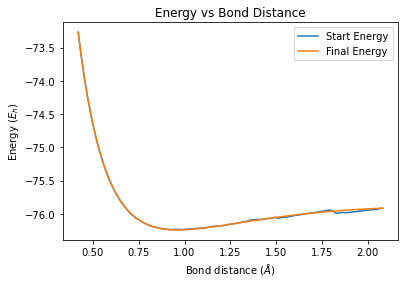

In [13]:
# Plotting the start energy and final energy against bond distance

zipped_lists = zip(OH_distance, startEnergy, finalEnergy)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
BondDistance, StartEnergy, FinalEnergy = [ list(tuple) for tuple in  tuples]

plt.title('Energy vs Bond Distance')
plt.xlabel('Bond distance ($\AA$)')
plt.ylabel('Energy ($E_{h}$)')
plt.plot(BondDistance, StartEnergy, label = 'Start Energy')
plt.plot(BondDistance, FinalEnergy, label = 'Final Energy')
plt.legend(loc="upper right")
plt.show()